# Diffusion Model

**Goal:** We just learned about Diffusion models, both the stochastic differential equation continuous formulation and the way to solve them in discrete space with Deep Denoising Probabilistic Models.

This afternoon we're going to be working with the _same_ binary black hole merger dataset from Annalena, but now... doing neural posterior estimation with a diffusion model

**Resources:**
- Diffusion model tutorial from Sofia Palacios + Theo Heimel [https://colab.research.google.com/drive/1Hlb3qpNvvfi2oBJ99pgoXrB6AF86fFZf?usp=sharing]

### Table of Contents
1. [Preprocessing](#Preprocessing)
2. [Defining the model](#model)
3. [Train the model](#train)
4. [Look at posteriors](#posteriors)

Nicole Hartman

ODSL GenAI Days

24 Sept 2024

In [1]:
# Installs if you're running on collab
!pip install corner
!pip install torchdiffeq


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
from typing import Union
import corner

from torch.utils.data import Dataset, DataLoader, random_split

%load_ext autoreload
%autoreload 2

In [3]:
# If running on CUDA is available, use the GPU.
# if torch.backends.mps.is_available():
#     device = "mps"
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
device

'cpu'

### Preprocessing

Here we will again load and preprocess the data we generated in the notebook `data_generation.ipynb` and saved under `01_normalizing_flows/data/training_dataset.pkl`.

However, you can also save the file to your google drive (and might have already done so in the last couple of days) so the code block below toggles `data_folder` to load from the relevant location.

In [5]:
'''
Warning: Might need to edit based on where the data is stored.
'''
try:
    # Try to load the google drive for google collab if you can
    from google.colab import drive
    drive.mount('/content/drive')
    
    data_folder="/content/drive/My Drive"
    
except:
    # Just look for the folder locally
    data_folder = '../01_normalizing_flows/data'


In [6]:
file_name = os.path.join(data_folder, 'dataset.pkl')

if not os.path.isfile(file_name):
    raise ValueError(f"File {file_name} does not exist, correct path or generate data set.")

with open(file_name, 'rb') as f:
    data = pickle.load(f)
print('Sucessfully loaded dataset with', len(data['hp']), 'waveforms.')

Sucessfully loaded dataset with 10000 waveforms.


Load in a pytorch Dataset and do the dataset preprocessing

In [7]:
class WaveformDataset(Dataset):

    def __init__(self, data):
        '''
        - data: As loaded from what we've saved from the
                data_generation nb
        '''

        parameters = torch.FloatTensor(data['masses'])

        # Standardize masses for training
        self.parameters_mean = torch.mean(parameters, axis=0)
        self.parameters_std = torch.std(parameters, axis=0)

        parameters_standardized = (parameters - self.parameters_mean) / self.parameters_std

        '''
        Pre-process waveforms:
        - truncate below f_min
        - re-package real and imaginary part
        - only use $h_+$ for simplicity
        '''
        hp = torch.tensor(data['hp'])
        f_min, T = data['f_min'], data['T']
        delta_f = 1/T

        lower_cut = int(f_min / delta_f)
        waveforms = torch.hstack([hp.real[:, lower_cut:], hp.imag[:, lower_cut:]])

        self.parameters = parameters_standardized
        self.waveforms = waveforms.float() # type-cast to torch.float32

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        '''
        Returns:
        params, t, cond_inputs (=data)
        [which we'll be calling x,t,y in the code]
        '''
        params = self.parameters[idx]
        signal = self.waveforms[idx]

        # Add unit normal noise to the signal
        noise = torch.randn(size = signal.shape)
        data = signal + noise

        return params.to(device), data.to(device)

# Returns data in the form (params, data)
waveform_dataset = WaveformDataset(data)

**Note:** The notation we'll use today is the same as the notation in the FM tutorial from yday, and also consistent w/ Eva's lecture.

The `waveform_dataset` will return data in the form: $x,y$ to model the posterior $p_\theta (x_1 | y)$ where

- $x$ = $x_1$: `params`  GW masses $\in \mathbb{R}^2$
- $y$: `data` we'll condition on, the $h_p$ strain signal

$x_t$ is the state space that gets transformed by the diffusion and $y$ is the conditioning vector.

### Split data into train and test dataset

In [8]:
# Split the dataset into training and test sets
num_samples = len(waveform_dataset)
train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

batch_size=64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
for x,y in train_dataloader:
    break

In [10]:
param_dim = x.shape[1]
context_dim = y.shape[1]

## 2. Defining the model <a name="velocity-NN"></a>

### Forward process

**From the lecture:**

The conditional probability distribution is a next vector prediction which is a Guassian w/ the mean scaled down by $\sqrt{1 - \beta_t}$ and the variance set to $\sqrt{\beta_t}$
.
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t;\sqrt{1-\beta_t} x_{t-1}, \sqrt{\beta_t})$$

$$x_t= \sqrt{1-\beta_t} x_{t-1}+ \sqrt{\beta_t} \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0,1)$$

We could start from x_0 and _marginalize_ over the latent variables $x_1, x_2 , \ldots, x_{t-1}$ to arrive at the conditional distribution

$$x(t | x_0) = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$$

which is _also Gaussian_ with the new variable $\bar{\alpha}_t = (1-\beta_0)(1-\beta_1)\cdots(1-\beta_t)$.




**Choices we need to make**

1) What to choose for $\beta_t$

As you can see in the first equation above $\sqrt{\beta_t}$ is how much the noise gets scaled by at every step. For the tutorial, we'll just choose a linear $\beta$ schedule but note the choice of **noise schedule**  has been the subjet of a lot of R&D in recent years! 


In [11]:
def linear_beta_schedule(
    n_steps: int   # number of time steps
) -> torch.Tensor: # beta values at the time steps, shape (n_steps, )
    scale = 1000 / n_steps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, n_steps, dtype=torch.float32).to(device)

2) How many time steps to make

- Let's just go w/ 100.


Classic "gotcha": It's easier to implement the code if $t \in \mathbb{N}$ so we can index lists w/ $t$ instead of having $t\in [0,1]$ as yesterday.

In [12]:
class DDPM(nn.Module):

    def __init__(self, 
                 param_dim: int, 
                 context_dim: int = None,
                 n_steps: int = 1000,    # number of time steps
                 hidden_dim: int = 64, # TODO           
    ):
        super().__init__()

        self.param_dim = param_dim
        self.n_steps = n_steps

        # Initialize alpha, beta and sigma constants for the given number of time steps
        self.betas = linear_beta_schedule(n_steps)

        alphas = 1 - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        
        self.sqrt_alphas_bar = torch.sqrt(alphas_bar)
        self.sqrt_one_minus_alphas_bar = torch.sqrt(1 - alphas_bar)
        self.sigmas = torch.sqrt(self.betas)
        '''
        TASK: Define a small NN to predict the noise
        '''
        self.net = nn.Sequential(
            nn.Linear(param_dim + context_dim + 1, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, param_dim)
        )
    
    def get_xt(self,x0,t,eps):
        '''
        Inputs:
        - x0
        - t
        - eps: noise
        
        Q) Your task: Calculate x_t        
        '''
        return self.sqrt_alphas_bar[t] * x0 + self.sqrt_one_minus_alphas_bar[t] * eps

    def get_mu(self,xt,t,y):
        '''
        Predict the _mean_ of the reverse process.
        Needed in the sample function

        YOUR TASK: IMPLEMENT
        '''
        Xin = torch.cat([xt, torch.full((xt.shape[0], 1), t, dtype=torch.float32), y], dim=1)
        out = xt - self.betas[t]/self.sqrt_one_minus_alphas_bar[t] * self.net(Xin)
        out /= self.sqrt_alphas_bar[t]
        return out

    
    def sample(
        self,
        y: torch.Tensor,       # The context vector
        keep_xt: bool = False, # whether to keep the intermediate x_t
    ) -> torch.Tensor:         # sampled data, shape (n_samples, param_dim) or (n_steps, n_samples, param_dim)
        '''
        Defined in backup slides of Eva's lecture
        '''
        n_samples = y.shape[0]
        xt = torch.randn(n_samples, self.param_dim)
        if keep_xt:
            xts = torch.zeros((n_samples, self.n_steps + 1, self.param_dim))
            xts[:, self.n_steps] = xt
        for t in reversed(range(1,self.n_steps)):
            
            z = torch.randn(n_samples, self.param_dim) if t > 1 else 0.

            eps_pred = self.net(torch.cat([xt, torch.full((xt.shape[0], 1), t, dtype=torch.float32), y], dim=1))

            x0_tilde = (1/self.sqrt_alphas_bar[t])*(xt - self.sqrt_one_minus_alphas_bar[t]*eps_pred)
            mu_tilde = self.get_mu(xt,t,y)
            xt = mu_tilde + self.sigmas[t] * z
            if keep_xt:
                xts[:, t] = x
        return xts if keep_xt else xt

In [13]:
torch.randn(*x.shape).shape

torch.Size([64, 2])

In [14]:
model = DDPM(param_dim,context_dim).to(device)

In [27]:
model.n_steps=100

In [28]:
model.sample(torch.randn(3,context_dim)) #.shape

tensor([[-0.1624, -1.8129],
        [-6.3020,  4.1765],
        [ 1.1016,  5.0816]], grad_fn=<AddBackward0>)

## 3. The Loss function + training <a name="velocity-NN"></a>

In [29]:
def get_losses(model, x0, y):
    '''
    Q) Fill out this function
    '''

    # Sample t as how many integer steps to take from 1 -> n_steps
    t = torch.randint(low=1,high=model.n_steps,size=(x0.shape[0],1)).to(device)
    eps = torch.randn(*x0.shape)

    xt = model.get_xt(x0,t,eps)
    eps_pred = model.net( torch.concatenate([xt,t,y],dim=1) )

    return torch.sum((eps - eps_pred)**2,axis=1)


Then the train and test loops are the same as yesterday.

In [17]:
# Training and test loops
def train_loop(dataloader, model, optimizer):

    model.train()

    size = len(dataloader.dataset)
    train_loss = 0

    for batch, (x,y) in enumerate(dataloader):

        loss = get_losses(model,x,y)

        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")

    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss


def test_loop(dataloader, model):

    model.eval()

    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for x,y in dataloader:
            loss = get_losses(model,x,y)
            test_loss += loss.sum()

    test_loss = test_loss.item() / size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

epochs = 500
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 2.639043  [    0/ 8000 samples]
Loss: 2.129246  [ 3200/ 8000 samples]
Loss: 1.901501  [ 6400/ 8000 samples]
Average loss: 2.0543
Test loss: 2.063322 

Epoch 2
-------------------------------
Loss: 1.607005  [    0/ 8000 samples]
Loss: 1.726608  [ 3200/ 8000 samples]
Loss: 1.571662  [ 6400/ 8000 samples]
Average loss: 1.8906
Test loss: 1.866846 

Epoch 3
-------------------------------
Loss: 1.934880  [    0/ 8000 samples]
Loss: 1.673634  [ 3200/ 8000 samples]
Loss: 1.487864  [ 6400/ 8000 samples]
Average loss: 1.6514
Test loss: 1.437481 

Epoch 4
-------------------------------
Loss: 1.624848  [    0/ 8000 samples]
Loss: 1.296605  [ 3200/ 8000 samples]
Loss: 1.101743  [ 6400/ 8000 samples]
Average loss: 1.2273
Test loss: 1.366154 

Epoch 5
-------------------------------
Loss: 1.110413  [    0/ 8000 samples]
Loss: 1.000240  [ 3200/ 8000 samples]
Loss: 0.732239  [ 6400/ 8000 samples]
Average loss: 0.8511
Test loss: 0.629627 

Epoch 6
-------

In [19]:
import pandas as pd

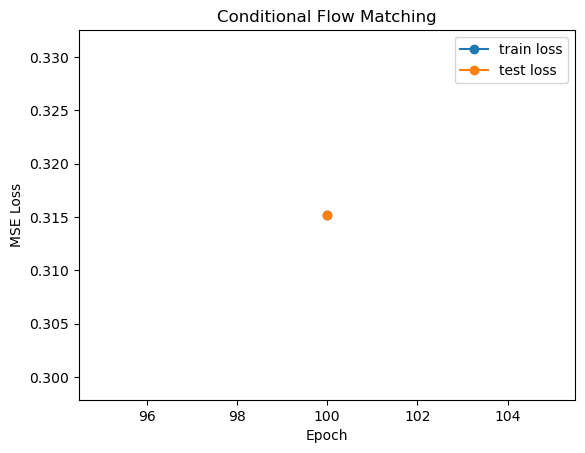

In [20]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, pd.Series(train_history).rolling(100).mean(),
         '-o', label = 'train loss')
plt.plot(epochs, pd.Series(train_history).rolling(100).mean(),
         '-o', label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Conditional Flow Matching')
plt.legend()
plt.show()

### 4. Visualize posteriors

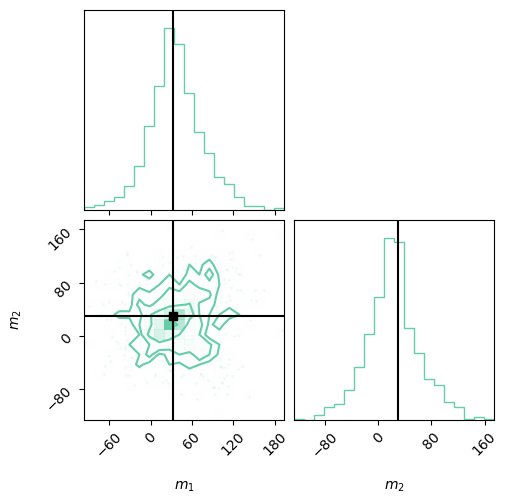

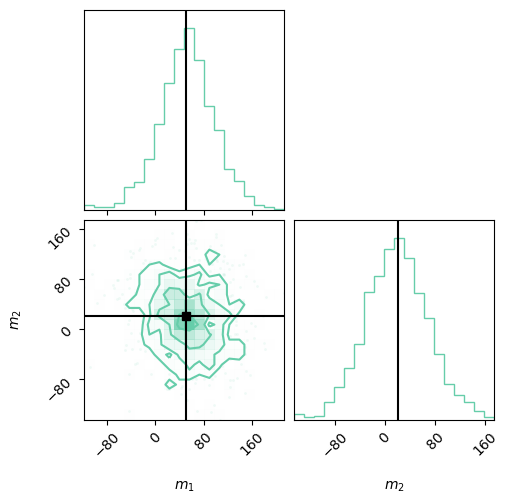

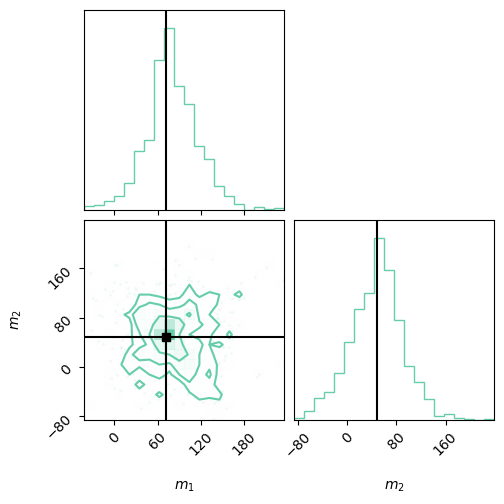

In [30]:
num_posteriors = 3
num_eval_samples = 1_000

model.eval()

for n in range(num_posteriors):

    with torch.no_grad():

        test_x, test_y = test_dataset[n]
       
        # Sample the posterior
        test_y = test_y.expand(num_eval_samples, *test_y.shape)
        pred_samples = model.sample(test_y).squeeze(1).cpu().numpy()
    
        # Undo the standardization
        parameters_mean = waveform_dataset.parameters_mean.numpy()
        parameters_std  = waveform_dataset.parameters_std.numpy()
        
        pred_samples = parameters_mean + pred_samples   * parameters_std
        truth        = parameters_mean + test_x.numpy() * parameters_std
    
        # Plot
        corner.corner(pred_samples, truths=truth, labels=['$m_1$', '$m_2$'],
                      color='mediumaquamarine',truth_color='k')
        plt.show()
